In [ ]:
"""
Vision Transformer (ViT) consists of the following key components:
-- Patch Embedding: Converts an image into a sequence of flattened patches.
-- Position Embedding: Adds positional information to the patches.
-- Transformer Encoder: Applies multiple layers of self-attention and feed-forward neural networks.
-- Classification Head: Maps the final representation to the class labels.
-- The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class has been used for image classification project
--Vision Transformer (ViT) has been applied for CIFAR image classification
-- compare the accuracy and performance of ViT with pure CNN and other transfer learning in TransferLearning-CIFAR-Project.ipynb
"""

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import classification_report

2024-09-04 08:47:14.787683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load and normalize CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Patch embedding layer
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (32 // patch_size) ** 2
        self.projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)
        self.flatten = layers.Reshape((-1, embed_dim))

    def call(self, x):
        x = self.projection(x)
        x = self.flatten(x)
        return x

# Transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.nn.gelu),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        # Self-attention block
        attn_output = self.attention(x, x)
        x = self.layernorm1(x + attn_output)
        # MLP block
        mlp_output = self.mlp(x)
        return self.layernorm2(x + mlp_output)

# Vision Transformer model
def create_vit_model(input_shape, num_classes, patch_size, num_layers, num_heads, embed_dim, mlp_dim, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = PatchEmbedding(patch_size, embed_dim)(inputs)
    # Add positional embedding
    positions = tf.range(start=0, limit=patches.shape[1], delta=1)
    position_embedding = layers.Embedding(input_dim=patches.shape[1], output_dim=embed_dim)(positions)
    x = patches + position_embedding
    # Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, mlp_dim, dropout_rate)(x)
    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    # Compile model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
# Define model parameters
input_shape = (32, 32, 3)
num_classes = 10
patch_size = 4
num_layers = 6
num_heads = 4
embed_dim = 64
mlp_dim = 128
dropout_rate = 0.1

# Create the model
model = create_vit_model(
    input_shape=input_shape,
    num_classes=num_classes,
    patch_size=patch_size,
    num_layers=num_layers,
    num_heads=num_heads,
    embed_dim=embed_dim,
    mlp_dim=mlp_dim,
    dropout_rate=dropout_rate
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 patch_embedding (PatchEmbe  (None, 64, 64)            3136      
 dding)                                                          
                                                                 
 tf.math.add (TFOpLambda)    (None, 64, 64)            0         
                                                                 
 transformer_block (Transfo  (None, 64, 64)            83200     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 64, 64)            83200     
 formerBlock)                                                    
                                                             

In [10]:
# Training the model
history = model.fit(
    x_train , y_train,
    batch_size=64,
    epochs=20,
    validation_split=0.1
)


Epoch 1/20
704/704 [==============================] - 422s 577ms/step - loss: 1.9309 - accuracy: 0.3153 - val_loss: 1.4275 - val_accuracy: 0.4926
Epoch 2/20
704/704 [==============================] - 355s 504ms/step - loss: 1.3315 - accuracy: 0.5232 - val_loss: 1.1888 - val_accuracy: 0.5718
Epoch 3/20
704/704 [==============================] - 355s 505ms/step - loss: 1.1709 - accuracy: 0.5846 - val_loss: 1.1014 - val_accuracy: 0.6020
Epoch 4/20
704/704 [==============================] - 355s 505ms/step - loss: 1.0550 - accuracy: 0.6255 - val_loss: 0.9969 - val_accuracy: 0.6478
Epoch 5/20
704/704 [==============================] - 353s 501ms/step - loss: 0.9733 - accuracy: 0.6542 - val_loss: 0.9962 - val_accuracy: 0.6508
Epoch 6/20
704/704 [==============================] - 402s 570ms/step - loss: 0.9130 - accuracy: 0.6787 - val_loss: 0.9159 - val_accuracy: 0.6762
Epoch 7/20
704/704 [==============================] - 381s 540ms/step - loss: 0.8612 - accuracy: 0.6951 - val_loss: 0.9128 -

In [12]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 32s 102ms/step - loss: 0.9383 - accuracy: 0.7050


[0.9382582306861877, 0.7049999833106995]

313/313 [==============================] - 34s 108ms/step


<Axes: >

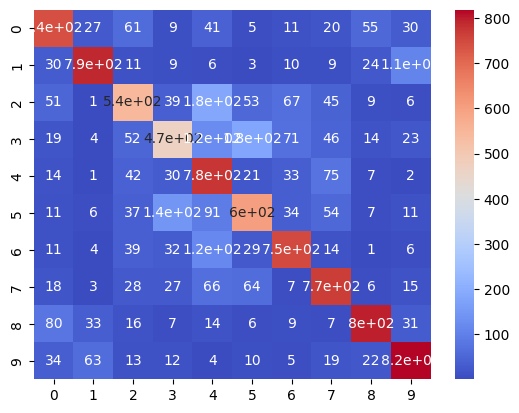

In [17]:
ypred=model.predict(x_test)
ypred=[np.argmax(i) for i in ypred]
y_test_sparse = np.argmax(y_test, axis=1)
cm=tf.math.confusion_matrix(y_test_sparse ,ypred)
sns.heatmap(cm, annot=True, cmap="coolwarm")

In [18]:
print(classification_report(y_test_sparse ,ypred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1000
           1       0.85      0.79      0.82      1000
           2       0.65      0.55      0.59      1000
           3       0.60      0.47      0.52      1000
           4       0.55      0.78      0.64      1000
           5       0.62      0.60      0.61      1000
           6       0.75      0.75      0.75      1000
           7       0.73      0.77      0.75      1000
           8       0.85      0.80      0.82      1000
           9       0.78      0.82      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

